In [2]:
import numpy as np
import pandas as pd
import datetime, os
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split

# tensorflow imports
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorboard.plugins.hparams import api as hp

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Embedding
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [3]:
#Loading the dataset
df = pd.read_json('https://raw.githubusercontent.com/kkityeungg/CE888_datascience_finalproject/main/spider/dev.json')

#Extract input and target data from the dataframe
questions = df['question']
queries = df['query']
x = df['question']
y = df['query']


In [4]:
#Check if there is any missing value in the dataset
df.isnull().values.any()

False

In [5]:
#Examples of inputs and outputs values looks
for sample_i in range(2):
  print('Questions {}:  {}'.format(sample_i + 1, questions[sample_i]))
  print('SQL query {}:  {}'.format(sample_i + 1, queries[sample_i]))

Questions 1:  How many singers do we have?
SQL query 1:  SELECT count(*) FROM singer
Questions 2:  What is the total number of singers?
SQL query 2:  SELECT count(*) FROM singer


In [6]:
import collections
questions_words_counter = collections.Counter([word for sentence in questions for word in sentence.split()])
queries_words_counter = collections.Counter([word for sentence in queries for word in sentence.split()])

print('In the training data set')
print('{} words in questions.'.format(len([word for sentence in questions for word in sentence.split()])))
print('{} unique words.'.format(len(questions_words_counter)))
print('10 Most common words in the questions dataset:')
print('"' + '" "'.join(list(zip(*questions_words_counter.most_common(10)))[0]) + '"')
print()
print('{} words in SQL queries.'.format(len([word for sentence in queries for word in sentence.split()])))
print('{} unique words.'.format(len(queries_words_counter)))
print('10 Most common words in the SQL queries dataset:')
print('"' + '" "'.join(list(zip(*queries_words_counter.most_common(10)))[0]) + '"')

In the training data set
12848 words in questions.
1447 unique words.
10 Most common words in the questions dataset:
"the" "of" "What" "and" "are" "is" "in" "number" "name" "names"

16146 words in SQL queries.
1061 unique words.
10 Most common words in the SQL queries dataset:
"FROM" "SELECT" "=" "AS" "WHERE" "BY" "JOIN" "ON" "," "T1"


In [4]:
#Tokenization
def tokenize(x):
  """
  Tokenize x
  :param x: List of sentences/strings to be tokenized
  :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
  """
  # TODO: Implement
  x_tk = Tokenizer()
  x_tk.fit_on_texts(x)

  return x_tk.texts_to_sequences(x), x_tk

#Padding
def pad(x, length=None):
  """
  Pad x
  :param x: List of sequences.
  :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
  :return: Padded numpy array of sequences
  """
  # TODO: Implement
  if length is None:
    length = max([len(sentence) for sentence in x])
  return pad_sequences(x, maxlen=length, padding='post', truncating='post')

def preprocess(x, y):
  """
  Preprocess x and y
  :param x: Feature List of sentences
  :param y: Label List of sentences
  :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
  """
  preprocess_x, x_tk = tokenize(x)
  preprocess_y, y_tk = tokenize(y)

  preprocess_x = pad(preprocess_x)
  preprocess_y = pad(preprocess_y)

  # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
  preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

  return preprocess_x, preprocess_y, x_tk, y_tk

In [8]:
preprocess_x, preprocess_y, x_tk, y_tk = preprocess(x, y)

x_sequence_length = preprocess_x.shape[1]
y_sequence_length = preprocess_y.shape[1]
x_vocab_size = len(x_tk.word_index)
y_vocab_size = len(y_tk.word_index)

print('Dataset Preprocessed')
print("Max question sentence length:", x_sequence_length)
print("Max query sentence length:", y_sequence_length)
print("Question vocabulary size:", x_vocab_size)
print("Query vocabulary size:", y_vocab_size)


Dataset Preprocessed
Max question sentence length: 28
Max query sentence length: 73
Question vocabulary size: 924
Query vocabulary size: 511


In [9]:
#Split data 70% for training, 30% test
x_train, x_test, y_train, y_test = train_test_split(preprocess_x, preprocess_y, test_size=0.3, random_state=99)

print(len(x_train), 'train sequences', x_train.shape)
print(len(x_test), 'test sequences', x_test.shape)

723 train sequences (723, 28)
311 test sequences (311, 28)


## **Recurrent Neural Network (RNN) Model**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 73, 128)           50304     
                                                                 
 dropout (Dropout)           (None, 73, 128)           0         
                                                                 
 gru_1 (GRU)                 (None, 73, 128)           99072     
                                                                 
 dropout_1 (Dropout)         (None, 73, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 73, 256)          33024     
 ibuted)                                                         
                                                                 
 dropout_2 (Dropout)         (None, 73, 256)           0         
                                                        

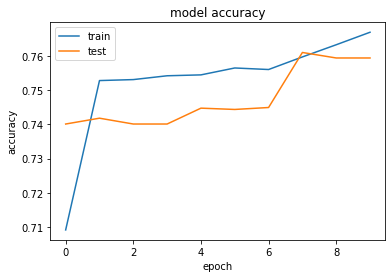

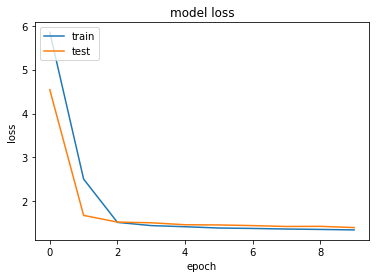

In [10]:
from keras.layers import GRU, Input, Dense, TimeDistributed, Dropout, LSTM
from keras.models import Model, Sequential
from keras.layers import Bidirectional
from keras.losses import sparse_categorical_crossentropy

def simple_rnn_model(input_shape, output_sequence_length, question_vocab_size, query_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param question_vocab_size: Number of unique words in the dataset
    :param query_vocab_size: Number of unique words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Build the layers
    model = Sequential()
    model.add(GRU(128, input_shape=input_shape[1:], return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(256, activation='relu')))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(query_vocab_size, activation='softmax'))) 
     
     
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer="adam",
                  metrics=['accuracy'])
    return model
 
# Reshaping the input to work with a basic RNN
tmp_x = pad(x_train, y_train.shape[1])
tmp_x = tmp_x.reshape((-1, y_train.shape[-2], 1))
 
# Train the neural network
simple_rnn_model = simple_rnn_model(
    tmp_x.shape,
    y_sequence_length,
    x_vocab_size,
    y_vocab_size)
simple_rnn_model.summary()
simple_rnn_history = simple_rnn_model.fit(tmp_x, y_train, batch_size=64, epochs=10, validation_split=0.2)
print("Average training accuracy: ", np.average(simple_rnn_history.history['accuracy']))
print("Average training loss: ", np.average(simple_rnn_history.history['loss']))

print(simple_rnn_history.history.keys())
# summarize history for accuracy
plt.plot(simple_rnn_history.history['accuracy'])
plt.plot(simple_rnn_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(simple_rnn_history.history['loss'])
plt.plot(simple_rnn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **Long Short-term Memory (LSTM) Model Model**

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 73, 128)           66560     
                                                                 
 dropout_42 (Dropout)        (None, 73, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 73, 128)           131584    
                                                                 
 dropout_43 (Dropout)        (None, 73, 128)           0         
                                                                 
 time_distributed_28 (TimeDi  (None, 73, 256)          33024     
 stributed)                                                      
                                                                 
 dropout_44 (Dropout)        (None, 73, 256)           0         
                                                     

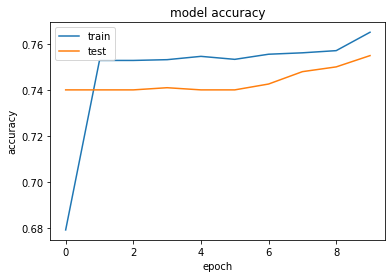

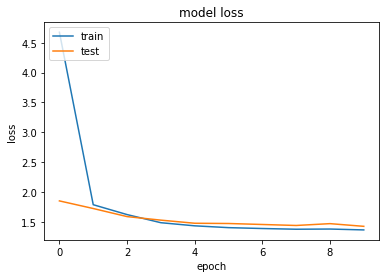

In [43]:
def lstm_model(input_shape, output_sequence_length, question_vocab_size, query_vocab_size):
  """
  Build and train a bidirectional RNN on x and y
  :param input_shape: Tuple of input shape
  :param output_sequence_length: Length of output sequence
  :param question_vocab_size: Number of unique words in the question dataset
  :param query_vocab_size: Number of unique words in the query dataset
  :return: Keras model built, but not trained
  """
  # TODO: Build the layers
  model = Sequential()
  model.add(LSTM(128, input_shape=input_shape[1:], return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(128, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(TimeDistributed(Dense(256, activation='tanh')))
  model.add(Dropout(0.2))
  model.add(TimeDistributed(Dense(query_vocab_size, activation='softmax'))) 
  model.compile(loss=sparse_categorical_crossentropy,
                optimizer="adam",
                metrics=['accuracy'])
  return model
 
# Reshaping the input to work with a bidirectional RNN
tmp_x = pad(x_train, y_sequence_length)
tmp_x = tmp_x.reshape((-1, y_train.shape[-2], 1))

# Train the neural network
lstm_model = lstm_model(
    tmp_x.shape,
    y_sequence_length,
    x_vocab_size,
    y_vocab_size)
lstm_model.summary()
lstm_history = lstm_model.fit(tmp_x, y_train, batch_size=64, epochs=10, validation_split=0.2)
print("Average training accuracy: ", np.average(lstm_history.history['accuracy']))
print("Average training loss: ", np.average(lstm_history.history['loss']))

print(lstm_history.history.keys())
# summarize history for accuracy
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **Encoder-Decoder**

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 73, 1)]           0         
                                                                 
 gru_24 (GRU)                (None, 73)                16644     
                                                                 
 dense_30 (Dense)            (None, 128)               9472      
                                                                 
 repeat_vector (RepeatVector  (None, 73, 128)          0         
 )                                                               
                                                                 
 gru_25 (GRU)                (None, 73, 128)           99072     
                                                                 
 time_distributed_30 (TimeDi  (None, 73, 511)          65919     
 stributed)                                                  

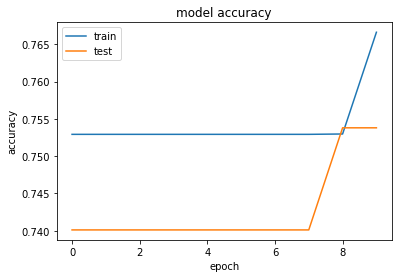

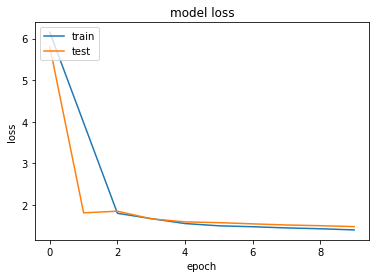

In [44]:
def en_de_model(input_shape, output_sequence_length, question_vocab_size, query_vocab_size):
  """
  Build and train a encoder-decoder model on x and y
  :param input_shape: Tuple of input shape
  :param output_sequence_length: Length of output sequence
  :param question_vocab_size: Number of unique words in the question dataset
  :param query_vocab_size: Number of unique words in the query dataset
  :return: Keras model built, but not trained
  """
  model = Sequential()
  #Encoder
  inputs = Input(shape=input_shape[1:])
  gru = GRU(output_sequence_length)(inputs)
  e_out = Dense(128, activation='relu')(gru) 
  #Decoder
  d_input = RepeatVector(output_sequence_length)(e_out)
  d_gru = GRU(128, return_sequences=True)(d_input)
  layer = TimeDistributed(Dense(query_vocab_size, activation='softmax'))
  final = layer(d_gru)
  #Create Model from parameters defined above
  model = Model(inputs=inputs, outputs=final)
  model.compile(loss=sparse_categorical_crossentropy,
                optimizer='adam',
                metrics=['accuracy'])
  return model

# Reshaping the input to work with a bidirectional RNN
tmp_x = pad(x_train, y_sequence_length)
tmp_x = tmp_x.reshape((-1, y_train.shape[-2], 1))

en_de_model = en_de_model(
    tmp_x.shape,
    y_sequence_length,
    x_vocab_size,
    y_vocab_size)
en_de_model.summary()

en_de_history = en_de_model.fit(tmp_x, y_train, batch_size=64, epochs=10, validation_split=0.2)
print("Average training accuracy: ", np.average(en_de_history.history['accuracy']))
print("Average training loss: ", np.average(en_de_history.history['loss']))

print(en_de_history.history.keys())
# summarize history for accuracy
plt.plot(en_de_history.history['accuracy'])
plt.plot(en_de_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(en_de_history.history['loss'])
plt.plot(en_de_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **Embeddings and Bidirectional LSTM**

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28, 100)           92400     
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dense_32 (Dense)            (None, 256)               65792     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 73, 256)          0         
 or)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 73, 512)          1050624   
 nal)                                                            
                                                     

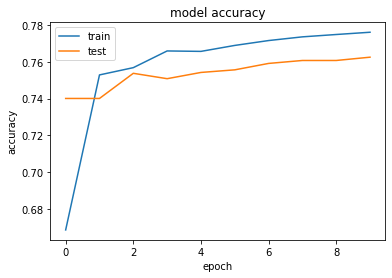

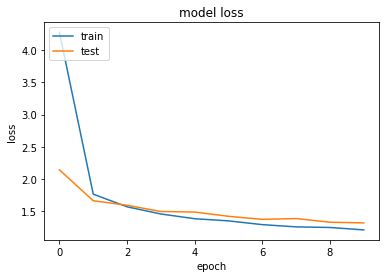

In [45]:
from pandas.core.algorithms import mode
from tensorflow import keras
from keras import layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint

def bi_lstm_model(input_shape, output_shape, question_vocab_size, query_vocab_size):
  """
  Build and train a bidirectional RNN on x and y
  :param input_shape: Tuple of input shape
  :param output_sequence_length: Length of output sequence
  :param question_vocab_size: Number of unique words in the question dataset
  :param query_vocab_size: Number of unique words in the query dataset
  :return: Keras model built, but not trained
  """
  model = keras.Sequential()
  model.add(Input(shape=input_shape[1:]))
  model.add(Embedding(question_vocab_size, 100))
  model.add(Bidirectional(layers.LSTM(128)))
  model.add(Dense(256, activation='relu'))
  model.add(RepeatVector(output_shape[1]))
  model.add(Bidirectional(layers.LSTM(256, dropout=0.2, return_sequences=True)))
  model.add(TimeDistributed(Dense(query_vocab_size, activation='softmax')))
  model.compile(loss=sparse_categorical_crossentropy, 
                optimizer="adam", 
                metrics=['accuracy'])
  return model

bi_lstm_model = bi_lstm_model(
    x_train.shape,
    y_train.shape,
    x_vocab_size,
    y_vocab_size)

bi_lstm_model.summary()
bi_lstm_history = bi_lstm_model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.2)
print("Average test accuracy: ", np.average(bi_lstm_history.history['accuracy']))
print("Average test loss: ", np.average(bi_lstm_history.history['loss']))

print(bi_lstm_history.history.keys())
# summarize history for accuracy
plt.plot(bi_lstm_history.history['accuracy'])
plt.plot(bi_lstm_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(bi_lstm_history.history['loss'])
plt.plot(bi_lstm_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

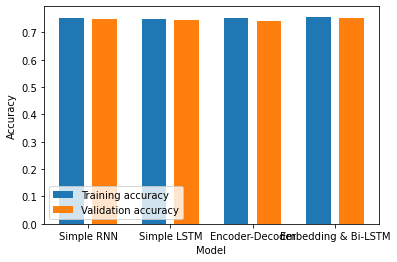

In [46]:
# Plotting average accuracy and validation accuracy amongst models
x = np.arange(4)
y1 = [np.average(simple_rnn_history.history['accuracy']), np.average(lstm_history.history['accuracy']), np.average(en_de_history.history['accuracy']), np.average(bi_lstm_history.history['accuracy'])]
y2 = [np.average(simple_rnn_history.history['val_accuracy']), np.average(lstm_history.history['val_accuracy']), np.average(en_de_history.history['val_accuracy']), np.average(bi_lstm_history.history['val_accuracy'])]
width = 0.3

# plot data in grouped manner of bar type
plt.bar(x-0.2, y1, width)
plt.bar(x+0.2, y2, width)
plt.xticks(x, ['Simple RNN', 'Simple LSTM', 'Encoder-Decoder', 'Embedding & Bi-LSTM'])
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.legend(["Training accuracy", "Validation accuracy"], loc='lower left')
plt.savefig('accuracy.png')
plt.show()


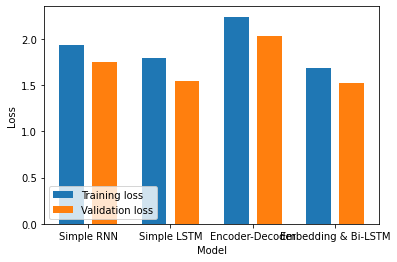

In [47]:
# Plotting average loss and validation loss amongst models
x = np.arange(4)
y1 = [np.average(simple_rnn_history.history['loss']), np.average(lstm_history.history['loss']), np.average(en_de_history.history['loss']), np.average(bi_lstm_history.history['loss'])]
y2 = [np.average(simple_rnn_history.history['val_loss']), np.average(lstm_history.history['val_loss']), np.average(en_de_history.history['val_loss']), np.average(bi_lstm_history.history['val_loss'])]
width = 0.3

# plot data in grouped manner of bar type
plt.bar(x-0.2, y1, width)
plt.bar(x+0.2, y2, width)
plt.xticks(x, ['Simple RNN', 'Simple LSTM', 'Encoder-Decoder', 'Embedding & Bi-LSTM'])
plt.xlabel("Model")
plt.ylabel("Loss")
plt.legend(["Training loss", "Validation loss"], loc='lower left')
plt.savefig('loss.png')
plt.show()


In [ ]:
#Create values of Hyper-parameter
HP_NUM_UNITS1 = hp.HParam('num_units1', hp.Discrete([128, 256, 512]))
HP_NUM_UNITS2 = hp.HParam('num_units2', hp.Discrete([256, 512]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd','RMSprop']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS1, HP_NUM_UNITS2, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [ ]:
#Hyper-parameter optimisation process
def train_test_model(hparams):
  """
  Define a function for testing different combinations of hyper-parameter setting
  :hparams: a nest list of values
  :return: training and vaildation accuracy for each epoch
  """
  model = tf.keras.models.Sequential([
    Input(shape=x_train.shape[1:]),
    Embedding(x_vocab_size, 100),
    Bidirectional(layers.LSTM(hparams[HP_NUM_UNITS1], return_sequences=True)),
    Bidirectional(layers.LSTM(hparams[HP_NUM_UNITS1], return_sequences=False)),
    Dense(hparams[HP_NUM_UNITS2], activation='relu'),
    RepeatVector(y_sequence_length),
    Bidirectional(layers.LSTM(hparams[HP_NUM_UNITS2], dropout=0.5, return_sequences=True)),
    TimeDistributed(Dense(y_vocab_size, activation='softmax'))
  ])
  model.compile(
    optimizer=hparams[HP_OPTIMIZER],
    loss=sparse_categorical_crossentropy,
    metrics=['accuracy']
  )
  model.fit(x_train, y_train, epochs=5)
  _, accuracy = model.evaluate(x_test, y_test)
  return accuracy

In [ ]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [ ]:
session_num = 0

for num_units1 in HP_NUM_UNITS1.domain.values:
  for num_units2 in HP_NUM_UNITS2.domain.values:
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS1: num_units1,
          HP_NUM_UNITS2: num_units2,
          HP_OPTIMIZER: optimizer
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

In [ ]:
#Update the log files of hyper-parameters to tensorboard.dev
!tensorboard dev upload --logdir logs

In [ ]:
import tensorboard as tb

experiment_id = "gNCYQ6zTRSWNCdle8eW5Xw"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
hp_df = experiment.get_scalars()


In [ ]:
HP_df = pd.read_csv('https://raw.githubusercontent.com/kkityeungg/CE888_datascience_finalproject/main/hparams_table.csv')
HP_df


In [5]:
df = pd.read_json('https://raw.githubusercontent.com/kkityeungg/CE888_datascience_finalproject/main/spider/train_spider.json')
x = df['question']
y = df['query']

preprocess_x, preprocess_y, x_tk, y_tk = preprocess(x, y)

x_sequence_length = preprocess_x.shape[1]
y_sequence_length = preprocess_y.shape[1]
x_vocab_size = len(x_tk.word_index)
y_vocab_size = len(y_tk.word_index)

x_train, x_test, y_train, y_test = train_test_split(preprocess_x, preprocess_y, test_size=0.3, random_state=99)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 38)]              0         
                                                                 
 embedding (Embedding)       (None, 38, 100)           322100    
                                                                 
 bidirectional (Bidirectiona  (None, 38, 256)          234496    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 repeat_vector (RepeatVector  (None, 117, 256)         0     

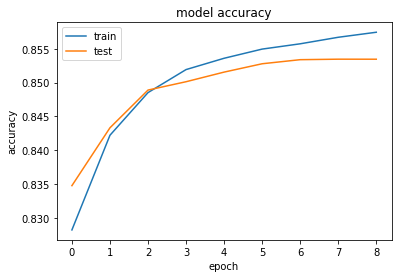

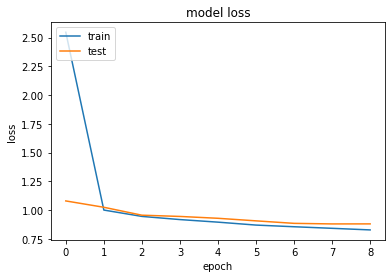

In [6]:
from pandas.core.algorithms import mode
from tensorflow import keras
from keras import layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import GRU, Input, Dense, TimeDistributed, Dropout, LSTM

def model_final(input_shape, output_sequence_length, question_vocab_size, query_vocab_size):
  """
  Build and train a embedding and bidirectional LSTM on x and y
  :param input_shape: Tuple of input shape
  :param output_sequence_length: Length of output sequence
  :param question_vocab_size: Number of unique words in the question dataset
  :param query_vocab_size: Number of unique words in the query dataset
  :return: Keras model built, but not trained
  """
  inputs = Input(shape=input_shape[1:])
  emb = Embedding(question_vocab_size, 100)(inputs)
  en_lstm_layer1 = Bidirectional(LSTM(128, return_sequences=True))(emb)
  en_lstm_layer2 = Bidirectional(LSTM(128, return_sequences=False))(en_lstm_layer1)
  final_enc = Dense(256, activation='relu')(en_lstm_layer2)
    
  dec1 = RepeatVector(output_sequence_length)(final_enc)
  de_lstm_layer1 = Bidirectional(LSTM(256, dropout=0.5, return_sequences=True))(dec1)
  layer = TimeDistributed(Dense(query_vocab_size, activation='softmax'))
  final = layer(de_lstm_layer1)

  model = Model(inputs=inputs, outputs=final)
  model.compile(loss=sparse_categorical_crossentropy, 
                optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
                metrics=['accuracy'])
  return model

model_final = model_final(
    x_train.shape,
    y_train.shape[1],
    x_vocab_size+1,
    y_vocab_size+1)

callbacks = [EarlyStopping(monitor='val_loss', patience=1)]

model_final.summary()
model_final_history = model_final.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test), callbacks = callbacks)

print(model_final_history.history.keys())
# summarize history for accuracy
plt.plot(model_final_history.history['accuracy'])
plt.plot(model_final_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('final_accuracy.png')
plt.show()

# summarize history for loss
plt.plot(model_final_history.history['loss'])
plt.plot(model_final_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('final_loss.png')
plt.show()

In [7]:
print("Average train accuracy: ", np.average(model_final_history.history['accuracy']))
print("Average train loss: ", np.average(model_final_history.history['loss']))
print("Average val accuracy: ", np.average(model_final_history.history['val_accuracy']))
print("Average val loss: ", np.average(model_final_history.history['val_loss']))

Average train accuracy:  0.8499123917685615
Average train loss:  1.0764904618263245
Average val accuracy:  0.8490729464424981
Average val loss:  0.9414124488830566


In [8]:
for sample_i in range(2):
  print('Questions {}:  {}'.format(sample_i + 1, x[sample_i]))
  print('SQL query {}:  {}'.format(sample_i + 1, y[sample_i]))

Questions 1:  How many heads of the departments are older than 56 ?
SQL query 1:  SELECT count(*) FROM head WHERE age  >  56
Questions 2:  List the name, born state and age of the heads of departments ordered by age.
SQL query 2:  SELECT name ,  born_state ,  age FROM head ORDER BY age


In [9]:
y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
y_id_to_word[0] = '<PAD>'

sentence = 'how many heads of the departments are older than 56'
sentence = [x_tk.word_index[word] for word in sentence.split()]
sentence = pad_sequences([sentence], maxlen=x_train.shape[-1], padding='post')
sentences = np.array([sentence[0], x_train[0]])
predictions = model_final.predict(sentences, len(sentences))
print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]]))

select from from from from <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
